## **Importing libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive, files
import sys
import shap
drive.mount('/content/drive/')

# Sklearn Libraries
from sklearn.preprocessing import StandardScaler, label_binarize, MinMaxScaler
from sklearn.model_selection import train_test_split # import the splitting method from sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, precision_score, accuracy_score, recall_score, classification_report, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.inspection import permutation_importance # Used for seeing the importance of features
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold, chi2
from collections import Counter
from scipy.stats import ttest_ind
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from statsmodels.stats.multitest import multipletests


df = pd.read_csv('/content/drive/MyDrive/ADS2001 project/data/virtualInternshipData_aggregated.csv')
df = df.iloc[:, 1:].rename(columns={"a_OutcomeScore":"OutcomeScore"})
df['OutcomeScore'] = df['OutcomeScore'].astype(int)

Mounted at /content/drive/




---


## **Baseline Model**

[COMPLETED] We decided to use a very simple model --- kNN as the baseline model . See what the result it is

**Summary:**
- 🎯 Accuracy (Train): 0.644
- 🧪 Accuracy (Test): 0.376
- ⚠️ Imbalance might exist between scores.

Seeing that most of the data are categorical, the only approach that we could use is to have kNN as our baseline model.


In [2]:
def plt_confusion_matrix(cnf_matrix, cats, method):
    """
    Given actual target values and predicted values for a classifier 'method',
    plots the confusion matrix
    """
    # write the confusion matrix to a dataframe with row and column names as the categories
    cmatrix = pd.DataFrame(cnf_matrix,columns=cats,index=cats)
    f, ax = plt.subplots(figsize=(6,6)) # initialise the plots and axes
    sns.heatmap(cmatrix, annot=True, fmt = 'd',linewidths=.5) # plot the confusion matrix as a heatmap
    plt.title('Confusion matrix for '+method) # add a title, + concatenates two strings
    plt.ylabel('Actual label') # add a ylabel
    plt.xlabel('Predicted label') # add a xlabel
    # adjust the bottom and top of the figure, so we can view all of it
    bottom, top = ax.get_ylim()  # get the y axis limits
    ax.set_ylim(bottom + 0.5, top - 0.5); # adjust the y axis limits

In [3]:
n_neighbours = 3
X = df.copy().iloc[:, 2:-1]
y = df['OutcomeScore']

In [4]:
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.8,random_state=42)

baseline_clf = KNeighborsClassifier(n_neighbours, weights = 'uniform')
baseline_clf.fit(X_train, y_train)
y_pred = baseline_clf.predict(X_test)

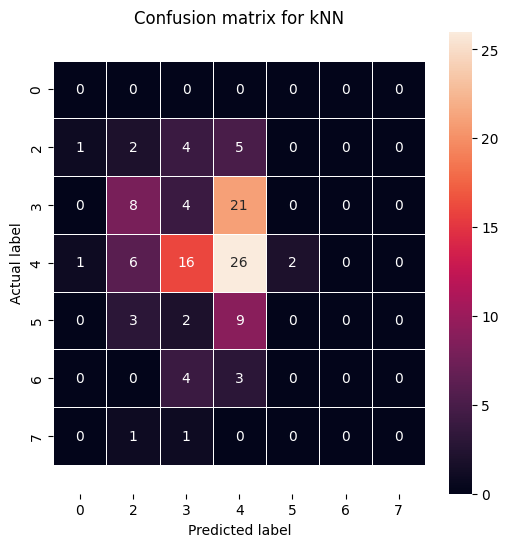

In [5]:
categories = np.unique(np.concatenate((y_test, y_pred)))
cnf_matrix = confusion_matrix(y_test, y_pred, labels = categories) # create a confusion matrix for our actual and predicted values
plt_confusion_matrix(cnf_matrix, categories, 'kNN')

 We can now calculate the accuracy of the model. This is simply the total number of correct predictions, i.e., the sum of the terms on the main diagonal of the confusion matrix, divided by the number of predictions, i.e., the sum of all the terms in the confusion matrix. In this case we have 4+26+18=48 correct predictions, and 133 total predictions. Therefore the accuracy in this case is 0.361. For a very good model the accuracy will approach 1, whereas for a very poor model the accuracy will approach 0.

In [6]:
baseline_train_accuracy = np.round(baseline_clf.score(X_train, y_train),3)
baseline_test_accuracy = np.round(baseline_clf.score(X_test, y_test),3)
baseline_report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
print("Accuracy (Train):",baseline_train_accuracy)
print("Accuracy (Test):",baseline_test_accuracy)

Accuracy (Train): 0.581
Accuracy (Test): 0.269



---


## **Overview of Data Processing**

[COMPLETED] We had already done sooo much work in Part 1. The following are just figures from the result of Part 1.

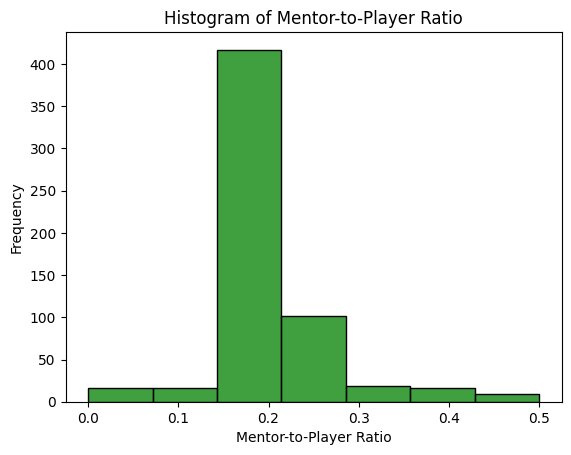

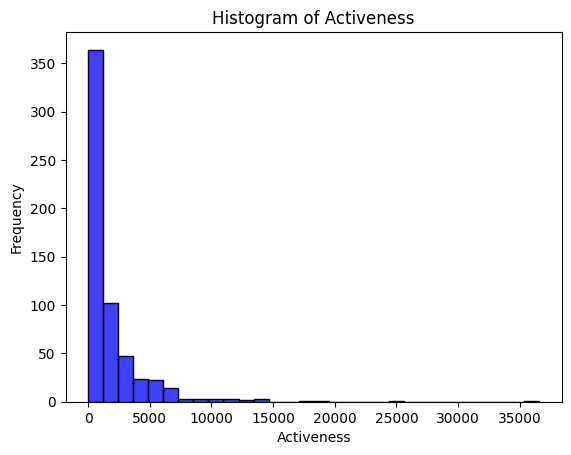

In [ ]:
# Histogram for 'mentor_to_player_ratio' column
sns.histplot(df['mentor_to_player_ratio'], bins=7, color = 'green')
plt.xlabel('Mentor-to-Player Ratio')
plt.ylabel('Frequency')
plt.title('Histogram of Mentor-to-Player Ratio')
plt.show()

# Histogram for 'activeness' column
sns.histplot(df['player_activeness'], bins=30, color='blue')
plt.xlabel('Activeness')
plt.ylabel('Frequency')
plt.title('Histogram of Activeness')
plt.show()


### **Sentiment Analysis**

<ipython-input-9-04bb27696ad2>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='groupIDs', y='binary_sentiment', data=df, inner="point", palette='viridis')


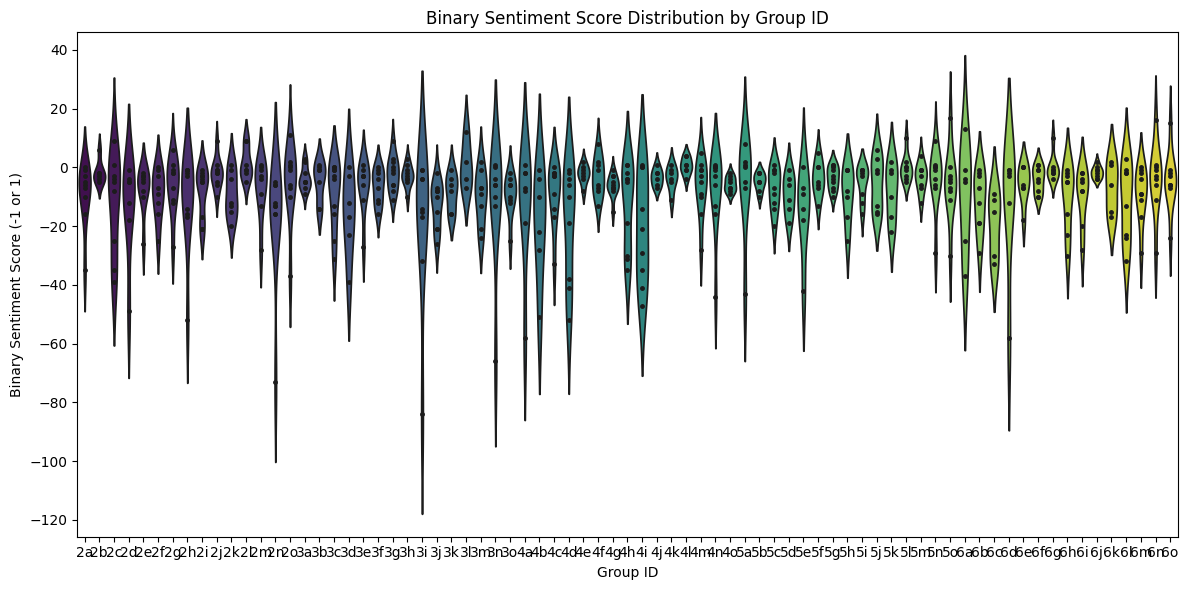

<ipython-input-9-04bb27696ad2>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='groupIDs', y='binary_sentiment', data=avg_binary, palette='viridis')


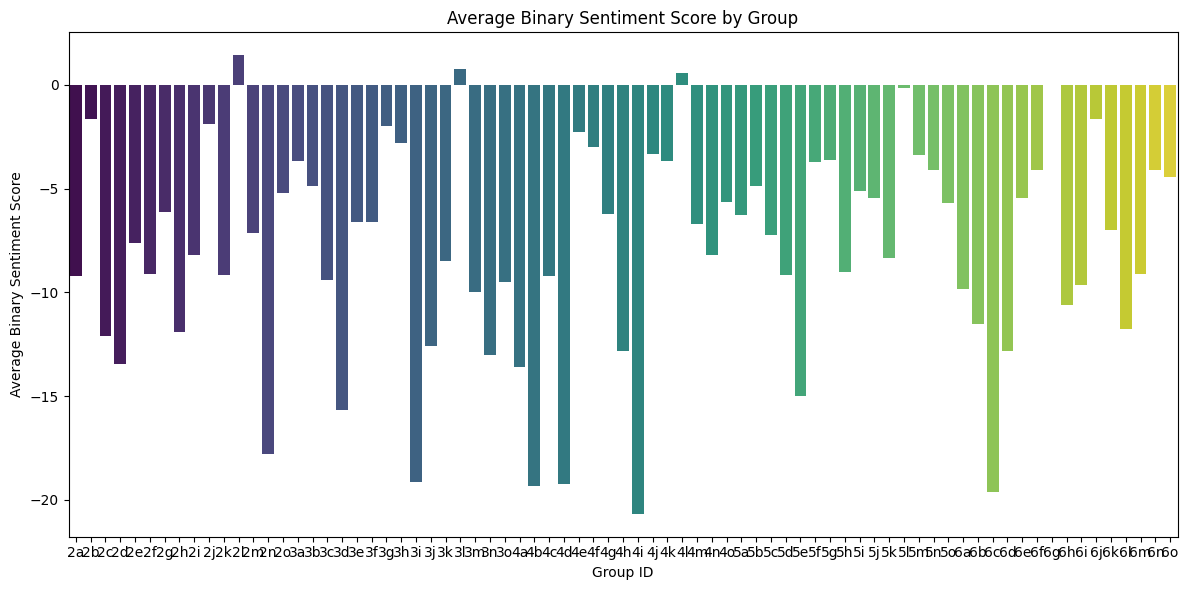

<ipython-input-9-04bb27696ad2>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='binary_sentiment', data=df,  palette='viridis')


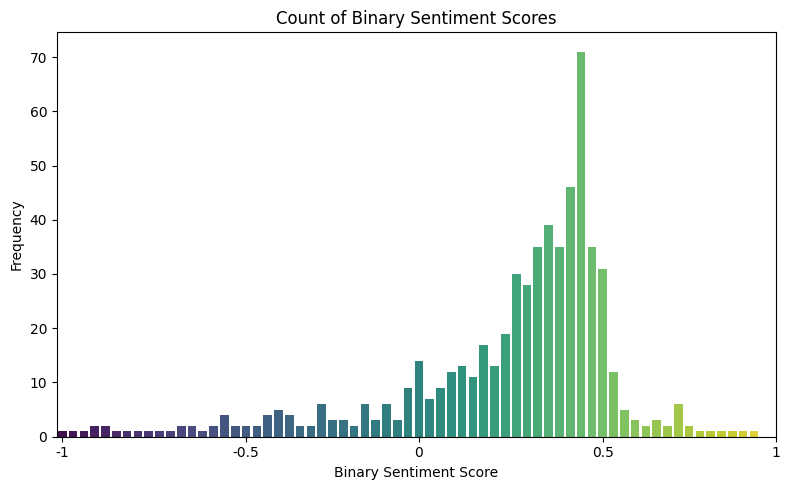

In [ ]:
#plot violin plot to show the sentiment score distribution by each group
plt.figure(figsize=(12, 6))
sns.violinplot(x='groupIDs', y='binary_sentiment', data=df, inner="point", palette='viridis')
plt.title('Binary Sentiment Score Distribution by Group ID')
plt.xlabel('Group ID')
plt.ylabel('Binary Sentiment Score (-1 or 1)')
plt.tight_layout()
plt.show()

# calculate the average sentiment score for each group
avg_sentiment_score = df.copy().groupby('groupIDs')['sentiment_score'].mean().reset_index()

# bar plot: average binary sentiment score for each group
avg_binary = df.copy().groupby('groupIDs')['binary_sentiment'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='groupIDs', y='binary_sentiment', data=avg_binary, palette='viridis')
plt.title('Average Binary Sentiment Score by Group')
plt.xlabel('Group ID')
plt.ylabel('Average Binary Sentiment Score')
plt.tight_layout()
plt.show()

# histogram: count of binary sentiment scores
plt.figure(figsize=(8, 5))
sns.countplot(x='binary_sentiment', data=df,  palette='viridis')
plt.title('Count of Binary Sentiment Scores')
plt.xlabel('Binary Sentiment Score')
plt.ylabel('Frequency')
plt.xticks(ticks=[0, 17, 33, 50, 66], labels=['-1', '-0.5', '0', '0.5', '1'])
plt.tight_layout()
plt.show()



---


## **Overview Effect of Data Processing**

[COMPLETED] So, there's A LOT stuff we did previously.

🤔Does it really mean anything to the baseline model? --- Does these all even necessary?

**Summary:**

- Aggregation (without feature engineering) ✅ Good improvement
- Mentor_to_player_ratio ✅ Good improvement
- Activeness ✅ Good improvement
- Sentiment ✅ Good improvement
- TF-IDF (the latest dataframe) ✅  Slightly dropped abit but looks ok.

Accuracy: 0.303 → 0.414 → 0.331 → 0.368 → 0.368 → 0.376

We would use `kNN` to see how each step we did for data processing affect the result. We would justify it based on:
1. Accuracy
2. Classification report

To see whether the following is really necessary:
- Converting to Group based data
- Doing `mentor_to_player_ratio`
- Doing `Activeness`
- Doing `Sentiment`
- Doing `TF-IDF`

In [ ]:
# List of all versions of your data
data_versions = {
    "Individual": pd.read_csv('/content/drive/MyDrive/ADS2001 project/data/virtualInternshipData_ADS2001.csv', encoding = 'ISO-8859-1').iloc[:, 7:],
    "Without FE": df.copy().iloc[:, list(range(8)) + [10, -1]],
    "With Ratio": df.copy().iloc[:, list(range(9)) + [-1]],
    "With Activeness": df.copy().iloc[:, list(range(10)) + [-1]],
    "With Sentiment": df.copy().iloc[:, list(range(13)) + [-1]],
    "With TF-IDF": df.copy()
}

In [ ]:
results = []

# Loop through each version
n_neighbours = 3
for name, df_variant in data_versions.items():
    X = df_variant.iloc[:, 2:].drop(columns=['OutcomeScore'])
    y = df_variant['OutcomeScore']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

    clf = KNeighborsClassifier(n_neighbors=3, weights='uniform')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    train_acc = clf.score(X_train, y_train)
    test_acc = clf.score(X_test, y_test)

    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

    precision = report['weighted avg']["precision"]
    recall = report['weighted avg']["recall"]
    f1 = report['weighted avg']["f1-score"]

    results.append({
        "Version": name,
        "Train Accuracy": round(train_acc, 3),
        "Test Accuracy": round(test_acc, 3),
        "Precision": round(precision, 3),
        "Recall": round(recall, 3),
        "F1-score": round(f1, 3),
    })

data_processing_evaluation = pd.DataFrame(results)
data_processing_evaluation

,Version,Train Accuracy,Test Accuracy,Precision,Recall,F1-score
0,Individual,0.328,0.303,0.276,0.303,0.288
1,Without FE,0.495,0.235,0.255,0.235,0.241
2,With Ratio,0.531,0.244,0.253,0.244,0.245
3,With Activeness,0.617,0.277,0.271,0.277,0.268
4,With Sentiment,0.598,0.286,0.233,0.286,0.256
5,With TF-IDF,0.581,0.269,0.220,0.269,0.241


**Observation**:

0. Ori data (Individual based)
  - Low accuracy and F1-score that indicates that individual-level data alone isn't sufficient for good predictions.

<br>

1. Without FE (Aggregated data)
  - Improved from the baseline in terms of both accuracy (0.278) and macro F1-score (0.165).

<br>

2. With Ratio (Mentor-to-Player Ratio)
  - Improvement in test accuracy (0.316) and macro F1-score (0.179).
  - This adds value as the ratio can have predictive power in team dynamics.
  - The improvement suggests it's a **valid feature** to include in team-based predictions.

<br>

3. With Activeness
  - test accuracy jumps to 0.398, and macro F1-score reaches 0.258.
  - Activeness is a strong predictor of success in many settings. This model shows that engagement is crucial and can contribute positively to the prediction task.

<br>

4. With Sentiment
  - There's a slight drop in performance (test accuracy of 0.323, macro F1-score of 0.206).
  - Optional, as its addition doesn’t improve the model substantially.

<br>

5. With TF-IDF
  - There’s a small improvement (test accuracy of 0.331, macro F1-score of 0.211).
  - TF-IDF can capture semantic meaning, which may help in understanding the content of team discussions. Although the improvement is incremental, it contributes to the model’s overall ability to capture context from communication. It could be highly beneficial for teams that rely heavily on written communication.



---



## **Normalisation**

[COMPLETED] There might be a need for normalisation to be done.

Summary: The result could be doubted.


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_normalised = scaler.fit_transform(X)
y = df['OutcomeScore']

X_train,X_test,y_train,y_test=train_test_split(X_normalised,y,train_size=0.8,random_state=42)

norm_clf = KNeighborsClassifier(n_neighbours, weights='uniform')
norm_clf.fit(X_train, y_train)
y_pred = norm_clf.predict(X_test)

In [ ]:
norm_cnf_matrix = confusion_matrix(y_test, y_pred) # create a confusion matrix for our actual and predicted values

In [ ]:
categories = np.unique(np.concatenate((y_test, y_pred)))

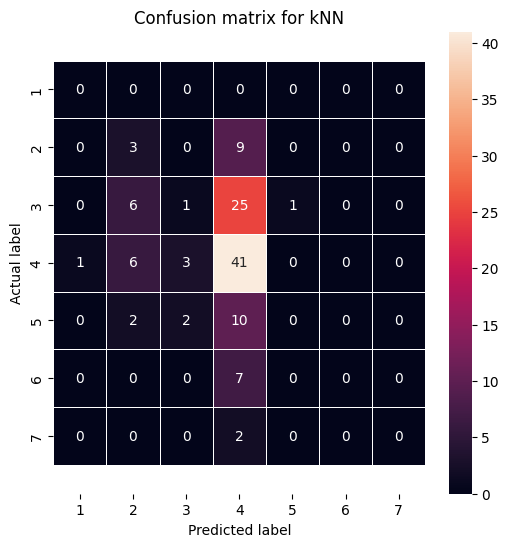

In [ ]:
plt_confusion_matrix(norm_cnf_matrix, categories, 'kNN')

In [ ]:
norm_train_accuracy = np.round(norm_clf.score(X_train, y_train),3)
norm_test_accuracy = np.round(norm_clf.score(X_test, y_test),3)
norm_report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
print("Accuracy (Train):", norm_train_accuracy)
print("Accuracy (Test):", norm_test_accuracy)

Accuracy (Train): 0.596
Accuracy (Test): 0.378


In [ ]:
normalisation_evaluation = pd.DataFrame({
    'Method': ['Baseline', 'After Normalisation'],
    'Number of Features': [
        len(df.iloc[:, 2:-1].columns),  # Original feature count
        len(df.iloc[:, 2:-1].columns)   # Same features after normalization
    ],
    'Accuracy (Train)': [
        baseline_train_accuracy,
        norm_train_accuracy
    ],
    'Accuracy (Test)': [
        baseline_test_accuracy,
        norm_test_accuracy
    ],
    'Precision': [
        baseline_report['weighted avg']['precision'],
        norm_report['weighted avg']['precision']
    ],
    'Recall': [
        baseline_report['weighted avg']['recall'],
        norm_report['weighted avg']['recall']
    ],
    'F1-Score': [
        baseline_report['weighted avg']['f1-score'],
        norm_report['weighted avg']['f1-score']
    ]
}).style.format({
    'Accuracy (Train)': '{:.3f}',
    'Accuracy (Test)': '{:.3f}',
    'Precision': '{:.3f}',
    'Recall': '{:.3f}',
    'F1-Score': '{:.3f}'
})
normalisation_evaluation

,Method,Number of Features,Accuracy (Train),Accuracy (Test),Precision,Recall,F1-Score
0,Baseline,4456,0.581,0.269,0.220,0.269,0.241
1,After Normalisation,4456,0.596,0.378,0.251,0.378,0.277


Not obvious effect since testing and training dropped.

---

## **Feature Selection**

[COMPLETED]
Method from ADS2002: Feature Selection is refered

In [7]:
features = df.copy().iloc[:, 2:-1]

**Multicollinearity**

First, we decide to investigate features that are highly-correlated between each other.

*The following code takes around 3-5 minutes to run*

In [8]:
corrs = features.corr() # calculate the correlation table
upper_tri = corrs.where(np.triu(np.ones(corrs.shape),k=1).astype(bool))
print('Minimum correlation is',np.round(upper_tri.min().min(),3))
print('Maximum correlation is',np.round(upper_tri.max().max(),3))

Minimum correlation is -0.742
Maximum correlation is 1.0


There exist definitely similar features, that therefore, we decide to remove all columns with abs(correlation) of >0.95

In [9]:
upper_tri = corrs.where(np.triu(np.ones(corrs.shape),k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(np.abs(upper_tri[column]) > 0.95)]
tfeatures = features.copy().drop(features[to_drop], axis=1)

In [14]:
print(f'Number of features to drop: \n {len(to_drop)}')
print(f'Features to drop: \n {to_drop}')
print(f'Number of features left: \n {len(tfeatures.columns)}')
high_corr_count = (upper_tri.abs() > 0.95).sum().sum()
print(f"Number of feature pairs with correlation > 0.95: {high_corr_count}")

Number of features to drop: 
 1627
Features to drop: 
 ['player_engagement', '170', '24', '250', '3hrs', '46', '4s', '530', '55', '600', '650000', '66', '669', '67', '78ng', '913', 'accordance', 'adapt', 'adjourn', 'advertiser', 'aesthetic', 'age', 'aggressive', 'agreeded', 'ahahah', 'ahoy', 'allan', 'allen', 'allows', 'amaze', 'amazingly', 'amen', 'amiability', 'amigos', 'anders', 'annotube', 'answers', 'appointment', 'approval', 'approx', 'arbitrary', 'aright', 'arrange', 'arrives', 'ash', 'ashlyn', 'ass', 'associate', 'assure', 'attached', 'attends', 'attraction', 'attractiveness', 'aw', 'aww', 'awwwwww', 'ayee', 'azuma', 'backwards', 'baised', 'band', 'batches', 'battle', 'bayleigh', 'beast', 'beforehand', 'beside', 'betchya', 'blame', 'blandly', 'bleeding', 'blends', 'blue', 'boil', 'bolivia', 'bomb', 'brc', 'bridgid', 'briefer', 'brigid', 'brown', 'brush', 'btg', 'buck', 'bug', 'bull', 'buying', 'callender', 'cancer', 'candle', 'capital', 'capitalism', 'carbonnanotubes', 'catalys

In [11]:
X = tfeatures.copy()
y = df['OutcomeScore']
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.8,random_state=42)

mult_clf = KNeighborsClassifier(n_neighbours, weights = 'uniform')
mult_clf.fit(X_train, y_train)
y_pred = mult_clf.predict(X_test)

mult_train_accuracy = np.round(mult_clf.score(X_train, y_train),3)
mult_test_accuracy = np.round(mult_clf.score(X_test, y_test),3)
mult_report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
print("Accuracy (Train):",mult_train_accuracy)
print("Accuracy (Test):",mult_test_accuracy)

Accuracy (Train): 0.587
Accuracy (Test): 0.269


As a result of solving multicollinearity, there exist less effect on accuracy, but reduced the dimensionality of the model

**Variance Treshold**

In [18]:
std_scores = pd.DataFrame(tfeatures.std())
std_scores.columns = ['Std']
std_scores.index.name = 'Feature'

print("Minimum standard deviation:")
print(std_scores['Std'].idxmin(), ' ', std_scores['Std'].min())
print("Maximum standard deviation:")
print(std_scores['Std'].idxmax(), ' ', std_scores['Std'].max())

# New addition: Count features with std < 0.10
low_std_count = (std_scores['Std'] < 0.10).sum()
print(f"Number of features with standard deviation < 0.10: {low_std_count}")


Minimum standard deviation:
mentor_activeness   0.0
Maximum standard deviation:
player_activeness   2999.3960255337456
Number of features with standard deviation < 0.10: 2148


This means that there exist Quasi-Constant Features in our features. Removal of features with low variance is needed.

In [ ]:
# Step 1: Calculate standard deviation for each column in tfeatures
std_scores = tfeatures.std()

# Step 2: Set a variance threshold (e.g., remove features with std < 0.01)
threshold = 0.01
to_drop = std_scores[std_scores < threshold].index

# Step 3: Drop low-variance features from tfeatures
selected_features_var = tfeatures.copy().drop(columns=to_drop)



In [ ]:
print(f'Number of features before setting treshold: \n {len(tfeatures.columns)}')
print(f'Number of features left: \n {len(selected_features_var)}')

Number of features before setting treshold: 
 2829
Number of features left: 
 594


In [ ]:
X = selected_features_var
y = df['OutcomeScore']
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.8,random_state=42)

var_clf = KNeighborsClassifier(n_neighbours, weights = 'uniform')
var_clf.fit(X_train, y_train)
y_pred = var_clf.predict(X_test)


var_train_accuracy = np.round(var_clf.score(X_train, y_train),3)
var_test_accuracy = np.round(var_clf.score(X_test, y_test),3)
var_report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
print("Accuracy (Train):", var_train_accuracy)
print("Accuracy (Test):", var_test_accuracy)

Accuracy (Train): 0.587
Accuracy (Test): 0.269


Further, the dimensionality is reduced. Without affecting much on accuracy.

<br>

**Short Conclusion on Feature Selection**


We evaluate the effect of removing feature by renmoving unnessary and unrelated columns.

The result could be evaluated below.



In [ ]:
feature_selection_evaluation = pd.DataFrame({
    'Method': ['Baseline', 'Solving Multicollinearity', 'Setting Variance Threshold'],
    'Number of Features': [
        len(df.iloc[:, 2:-1].columns),
        len(tfeatures.columns),
        len(selected_features_var)
    ],
    'Accuracy (Train)': [
        baseline_train_accuracy,
        mult_train_accuracy,
        var_train_accuracy
    ],
    'Accuracy (Test)': [
        baseline_test_accuracy,
        mult_test_accuracy,
        var_test_accuracy
    ],
    'Precision': [
        baseline_report['weighted avg']['precision'],
        mult_report['weighted avg']['precision'],
        var_report['weighted avg']['precision']
    ],
    'Recall': [
        baseline_report['weighted avg']['recall'],
        mult_report['weighted avg']['recall'],
        var_report['weighted avg']['recall']
    ],
    'F1-Score': [
        baseline_report['weighted avg']['f1-score'],
        mult_report['weighted avg']['f1-score'],
        var_report['weighted avg']['f1-score']
    ]
}).style.format({
    'Accuracy (Train)': '{:.3f}',
    'Accuracy (Test)': '{:.3f}',
    'Precision': '{:.3f}',
    'Recall': '{:.3f}',
    'F1-Score': '{:.3f}'
})
feature_selection_evaluation

,Method,Number of Features,Accuracy (Train),Accuracy (Test),Precision,Recall,F1-Score
0,Baseline,4456,0.581,0.269,0.220,0.269,0.241
1,Solving Multicollinearity,2829,0.587,0.269,0.222,0.269,0.242
2,Setting Variance Threshold,594,0.587,0.269,0.222,0.269,0.242




---


## **Statistical Testing**

We will do the following to conduct chi-squared, p-value and ANOVA testing:
1. Apply `SelectKBest` with chi-squared test, t-test and ANOVA on `features`
2. Extract chi-squared scores for each feature
3. Loop over number of features from 1 to max number of features to select the best number of features to take.
4. Evaluate the training and testing accuracy using filtered result.

In [20]:
features = df.copy().iloc[:, 2:-1]
labels = y.astype('category').cat.codes

# 1. Do Normalisation to convert to acceptable form of [0, 1].
features_non_neg = MinMaxScaler().fit_transform(features)

#2a. Chi-squared
chi2_scores, chi2_pvals = chi2(features_non_neg, labels)

# 2b. ANOVA f-test
f_scores, f_pvals = f_classif(features_non_neg, labels)

# 3a. Combine into 1 dataframe to make everything clearer
results = pd.DataFrame({
    'Feature': features.columns,
    'Chi2_Score': np.round(chi2_scores,2),
    'Chi2_PValue': chi2_pvals,
    'F_Score':  np.round(f_scores,2),
    'F_PValue': f_pvals
}).set_index('Feature')

# 3b. Sort by ANOVA F-score (or another metric)
results_sorted = results.sort_values(['F_Score', 'Chi2_Score'], ascending=False)

# 4. SHow
results_sorted.head(10)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [   8   13  262  357  573  755  757  780  817  905 1166 1253 1267 1789
 1933 1945 2140 2393 2499 2547 2638 2882 2996 3028 3078 3093 3106 3144
 3155 3205 3256 3296 3314 3510 3623 3628 3662 3856 3895 4015 4188 4227
 4266 4371] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


,Chi2_Score,Chi2_PValue,F_Score,F_PValue
Feature,,,,
describes,296.00,4.323574e-60,83.43,8.202970e-84
nuclear,147.50,1.359503e-28,27.72,5.753516e-33
reactor,147.50,1.359503e-28,27.72,5.753516e-33
michael,59.06,2.327891e-10,13.36,4.821192e-16
blatantly,73.25,3.248325e-13,11.80,4.271158e-14
glance,73.25,3.248325e-13,11.80,4.271158e-14
intro,73.25,3.248325e-13,11.80,4.271158e-14
no_factors,73.25,3.248325e-13,11.80,4.271158e-14
not_remote,73.25,3.248325e-13,11.80,4.271158e-14


In [21]:
bonferroni_threshold = 0.05 / len(results_sorted) #Bonferroni correction

# 1a. Chi2 p-value < 0.05
chi2_significant = results_sorted[results_sorted['Chi2_PValue'] < 0.05].index.tolist()
n_chi2_significant = len(chi2_significant)

#1b. Chi2 p-value < bonferroni-corrected threshold
chi2_b_significant = results_sorted[results_sorted['Chi2_PValue'] < bonferroni_threshold].index.tolist()
n_chi2_b_significant = len(chi2_significant)

# 2a. F-test p-value < 0.05
f_significant = results_sorted[results_sorted['F_PValue'] < 0.05].index.tolist()
n_f_significant = len(f_significant)

# 2b. F-test with Bonferroni correction
f_b_significant = results_sorted[results_sorted['F_PValue'] < bonferroni_threshold].index.tolist()
n_f_b_significant = len(f_significant)

# 3. BOTH p-values < 0.05
both_significant = results_sorted[
    (results_sorted['Chi2_PValue'] < 0.05) &
    (results_sorted['F_PValue'] < 0.05)
].index.tolist()
n_both_significant = len(both_significant)

# 3b. BOTH p-values < bonferroni threshold
both_b_significant = results_sorted[
    (results_sorted['Chi2_PValue'] < bonferroni_threshold) &
    (results_sorted['F_PValue'] < bonferroni_threshold)
].index.tolist()
n_both_b_significant = len(both_b_significant)

print(f"Number of features with Chi-squared p-value < 0.05: {n_chi2_significant}")
print(f"Number of features with Chi-squared p-value < {bonferroni_threshold} after Bonferroni correction: {n_chi2_b_significant}")
print(f"Number of features with ANOVA F-test p-value < 0.05: {n_f_significant}")
print(f"Number of features with ANOVA F-test p-value < {bonferroni_threshold} after Bonferroni correction: {n_f_b_significant}")
print(f"Number of features with BOTH p-values < 0.05: {n_both_significant}")
print(f"Number of features with BOTH p-values < {bonferroni_threshold} after Bonferroni correction: {n_both_b_significant}")

Number of features with Chi-squared p-value < 0.05: 136
Number of features with Chi-squared p-value < 1.1220825852782766e-05 after Bonferroni correction: 136
Number of features with ANOVA F-test p-value < 0.05: 206
Number of features with ANOVA F-test p-value < 1.1220825852782766e-05 after Bonferroni correction: 206
Number of features with BOTH p-values < 0.05: 136
Number of features with BOTH p-values < 1.1220825852782766e-05 after Bonferroni correction: 13


In [22]:
# The following is explanation why we are not considering other metrics other than Bonferroni
# For Chi² test
chi2_reject, chi2_adj_pvals, _, _ = multipletests(
    results_sorted['Chi2_PValue'],
    alpha=0.05,
    method='holm'  # Holm-Bonferroni
)

# For F-test
f_reject, f_adj_pvals, _, _ = multipletests(
    results_sorted['F_PValue'],
    alpha=0.05,
    method='holm'
)

other_metric_result = results_sorted.copy()

other_metric_result['Chi2_AdjPValue'] = chi2_adj_pvals

other_metric_result['F_AdjPValue'] = f_adj_pvals
# Features passing BH-adjusted Chi² test
chi2_bh_significant = other_metric_result[other_metric_result['Chi2_AdjPValue'] < 0.05].index.tolist()
n_chi2_bh_significant = len(chi2_bh_significant)

# Features passing BH-adjusted F-test
f_bh_significant = other_metric_result[other_metric_result['F_AdjPValue'] < 0.05].index.tolist()
n_f_bh_significant = len(chi2_bh_significant)

# Features passing BOTH tests
both_significant = other_metric_result[
    (other_metric_result['Chi2_AdjPValue'] < 0.05) &
    (other_metric_result['F_AdjPValue'] < 0.05)
].index.tolist()
n_both_bh_significant = len(both_significant)

print(chi2_adj_pvals.mean(), f_adj_pvals.mean())
print(f"Number of features with Chi-squared after BH correction: {n_chi2_bh_significant}")
print(f"Number of features with ANOVA F-test  after Bonferroni correction: {n_f_bh_significant}")
print(f"Number of features with BOTH  after Bonferroni correction: {n_both_bh_significant}")

# As other approach were bringing similar result as Bonferroni Procedure, there's no necessary to compare'
# that's why, we are selecting between Bonferroni Procedure and without it.

nan nan
Number of features with Chi-squared after BH correction: 13
Number of features with ANOVA F-test  after Bonferroni correction: 13
Number of features with BOTH  after Bonferroni correction: 13


In [ ]:
top_features = results_sorted.sort_values('Chi2_Score', ascending=False).head(20).index
plot_data = results_sorted.loc[top_features, ['Chi2_Score', 'F_Score']]
plot_data = plot_data.reset_index()
plot_data_melted = pd.melt( plot_data,id_vars='Feature',value_vars=['Chi2_Score', 'F_Score'],var_name='Metric',value_name='Score')

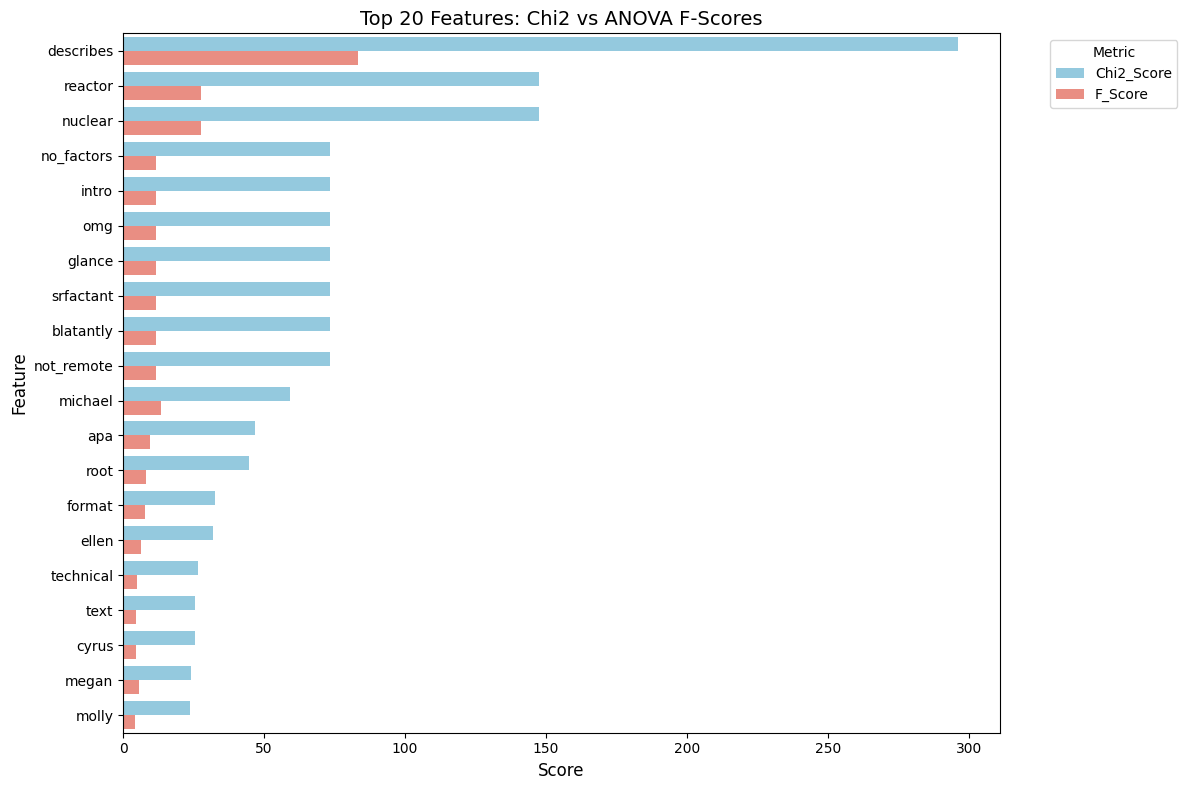

In [ ]:
plt.figure(figsize=(12, 8))
sns.barplot(
    data=plot_data_melted,
    x='Score',
    y='Feature',
    hue='Metric',
    palette={'Chi2_Score': 'skyblue', 'F_Score': 'salmon'},
    orient='h'
)

# Customize the plot
plt.title('Top 20 Features: Chi2 vs ANOVA F-Scores', fontsize=14)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
X = df[chi2_significant]
y = df['OutcomeScore']
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.8,random_state=42)

chi2_clf = KNeighborsClassifier(n_neighbours, weights = 'uniform')
chi2_clf.fit(X_train, y_train)
y_pred = chi2_clf.predict(X_test)

chi2_train_accuracy = np.round(chi2_clf.score(X_train, y_train),3)
chi2_test_accuracy = np.round(chi2_clf.score(X_test, y_test),3)
chi2_test_report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
print("Accuracy (Train):",chi2_train_accuracy)
print("Accuracy (Test):",chi2_test_accuracy)

Accuracy (Train): 0.545
Accuracy (Test): 0.437


In [ ]:
X = df[chi2_b_significant]
y = df['OutcomeScore']
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.8,random_state=42)

chi2_b_clf = KNeighborsClassifier(n_neighbours, weights = 'uniform')
chi2_b_clf.fit(X_train, y_train)
y_pred = chi2_b_clf.predict(X_test)

chi2_b_train_accuracy = np.round(chi2_b_clf.score(X_train, y_train),3)
chi2_b_test_accuracy = np.round(chi2_b_clf.score(X_test, y_test),3)
chi2_b_test_report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
print("Accuracy (Train):",chi2_b_train_accuracy)
print("Accuracy (Test):",chi2_b_test_accuracy)

Accuracy (Train): 0.486
Accuracy (Test): 0.437


In [ ]:
X = df[f_significant]
y = df['OutcomeScore']
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.8,random_state=42)

f_test_clf = KNeighborsClassifier(n_neighbours, weights = 'uniform')
f_test_clf.fit(X_train, y_train)
y_pred = f_test_clf.predict(X_test)

f_test_train_accuracy = np.round(f_test_clf.score(X_train, y_train),3)
f_test_test_accuracy = np.round(f_test_clf.score(X_test, y_test),3)
f_test_report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
print("Accuracy (Train):",f_test_train_accuracy)
print("Accuracy (Test):",f_test_test_accuracy)

Accuracy (Train): 0.617
Accuracy (Test): 0.429


In [ ]:
X = df[f_b_significant]
y = df['OutcomeScore']
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.8,random_state=42)

f_b_clf = KNeighborsClassifier(n_neighbours, weights = 'uniform')
f_b_clf.fit(X_train, y_train)
y_pred = f_b_clf.predict(X_test)

f_b_train_accuracy = np.round(f_b_clf.score(X_train, y_train),3)
f_b_test_accuracy = np.round(f_b_clf.score(X_test, y_test),3)
f_b_test_report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
print("Accuracy (Train):",f_b_train_accuracy)
print("Accuracy (Test):",f_b_test_accuracy)

Accuracy (Train): 0.516
Accuracy (Test): 0.412


In [ ]:
X = df[both_significant]
y = df['OutcomeScore']
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.8,random_state=42)

both_test_clf = KNeighborsClassifier(n_neighbours, weights = 'uniform')
both_test_clf.fit(X_train, y_train)
y_pred = both_test_clf.predict(X_test)

both_test_train_accuracy = np.round(both_test_clf.score(X_train, y_train),3)
both_test_test_accuracy = np.round(both_test_clf.score(X_test, y_test),3)
both_test_report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
print("Accuracy (Train):",both_test_train_accuracy)
print("Accuracy (Test):",both_test_test_accuracy)

Accuracy (Train): 0.486
Accuracy (Test): 0.437


In [ ]:
X = df[both_b_significant]
y = df['OutcomeScore']
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.8,random_state=42)

both_b_clf = KNeighborsClassifier(n_neighbours, weights = 'uniform')
both_b_clf.fit(X_train, y_train)
y_pred = both_b_clf.predict(X_test)

both_b_train_accuracy = np.round(both_b_clf.score(X_train, y_train),3)
both_b_test_accuracy = np.round(both_b_clf.score(X_test, y_test),3)
both_b_test_report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
print("Accuracy (Train):",both_b_train_accuracy)
print("Accuracy (Test):",both_b_test_accuracy)

Accuracy (Train): 0.486
Accuracy (Test): 0.437


In [ ]:
statistical_test_evaluation = pd.DataFrame({
    'Method': ['Baseline', 'F-test Filtration', 'F-test Filtration (After Bonferroni Correction)', 'Chi-squared Filtration', 'Chi-squared Filtration (After Bonferroni Correction)','Combined F-test + Chi-squared', 'Combined F-test + Chi-squared (After Bonferroni Correction)'],
    'Number of Features': [
        len(df.iloc[:, 2:-1].columns),
        n_f_significant,
        n_f_b_significant,
        n_chi2_significant,
        n_chi2_b_significant,
        n_both_significant,
        n_both_b_significant
    ],
    'Accuracy (Train)': [
        baseline_train_accuracy,
        f_test_train_accuracy,
        f_b_train_accuracy,
        chi2_train_accuracy,
        chi2_b_train_accuracy,
        both_test_train_accuracy,
        both_b_train_accuracy
    ],
    'Accuracy (Test)': [
        baseline_test_accuracy,
        f_test_test_accuracy,
        f_b_test_accuracy,
        chi2_test_accuracy,
        chi2_b_test_accuracy,
        both_test_test_accuracy,
        both_b_test_accuracy
    ],
    'Precision': [
        baseline_report['weighted avg']['precision'],
        f_test_report['weighted avg']['precision'],
        f_b_test_report['weighted avg']['precision'],
        chi2_test_report['weighted avg']['precision'],
        chi2_b_test_report['weighted avg']['precision'],
        both_test_report['weighted avg']['precision'],
        both_b_test_report['weighted avg']['precision']
    ],
    'Recall': [
        baseline_report['weighted avg']['recall'],
        f_test_report['weighted avg']['recall'],
        f_b_test_report['weighted avg']['recall'],
        chi2_test_report['weighted avg']['recall'],
        chi2_b_test_report['weighted avg']['recall'],
        both_test_report['weighted avg']['recall'],
        both_b_test_report['weighted avg']['recall']
    ],
    'F1-Score': [
        baseline_report['weighted avg']['f1-score'],
        f_test_report['weighted avg']['f1-score'],
        f_b_test_report['weighted avg']['f1-score'],
        chi2_test_report['weighted avg']['f1-score'],
        chi2_b_test_report['weighted avg']['f1-score'],
        both_test_report['weighted avg']['f1-score'],
        both_b_test_report['weighted avg']['f1-score']
    ]
}).style.format({
    'Accuracy (Train)': '{:.3f}',
    'Accuracy (Test)': '{:.3f}',
    'Precision': '{:.3f}',
    'Recall': '{:.3f}',
    'F1-Score': '{:.3f}'
})
statistical_test_evaluation

,Method,Number of Features,Accuracy (Train),Accuracy (Test),Precision,Recall,F1-Score
0,Baseline,4456,0.581,0.269,0.220,0.269,0.241
1,F-test Filtration,206,0.617,0.429,0.445,0.429,0.379
2,F-test Filtration (After Bonferroni Correction),206,0.516,0.412,0.439,0.412,0.316
3,Chi-squared Filtration,136,0.545,0.437,0.417,0.437,0.349
4,Chi-squared Filtration (After Bonferroni Correction),136,0.486,0.437,0.244,0.437,0.283
5,Combined F-test + Chi-squared,136,0.486,0.437,0.244,0.437,0.283
6,Combined F-test + Chi-squared (After Bonferroni Correction),13,0.486,0.437,0.244,0.437,0.283


## **Resampling**

In [ ]:
pd.DataFrame(classification_report(y_test, y_pred, zero_division=0, output_dict=True)).loc['support']

,support
1,0.000000
2,12.000000
3,33.000000
4,51.000000
5,14.000000
6,7.000000
7,2.000000
accuracy,0.436975
macro avg,119.000000
weighted avg,119.000000


We could say that there is a severe class imbalance in the dataset, with some classes having only a few instances (like 0.0 with 1 sample) and others having significantly more (like 4.0 with 50 samples). This imbalance makes it harder for the model to generalise well across all classes.

<br>

**Therefore,**
Techniques such as oversampling (like SMOTE) or undersampling could help the model better handle the class imbalance. Alternatively, class weights could be adjusted during model training to give more importance to the minority classes.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=42, stratify=y)  # Preserve class distribution in splits

# 1a. Oversampling
smote = SMOTE(random_state=42, k_neighbors = 1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
oversampling_clf = KNeighborsClassifier(n_neighbours, weights = 'uniform')
oversampling_clf.fit(X_train_resampled, y_train_resampled)
oversampling_y_pred = oversampling_clf.predict(X_test)
oversampling_train_accuracy = np.round(oversampling_clf.score(X_train, y_train),3)
oversampling_test_accuracy = np.round(oversampling_clf.score(X_test, y_test),3)
oversampling_report = classification_report(y_test, oversampling_y_pred, output_dict=True, zero_division=0)


# 1b. Undersampling
undersampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)
undersampling_clf = KNeighborsClassifier(n_neighbours, weights = 'uniform')
undersampling_clf.fit(X_train_under, y_train_under)
undersampling_y_pred = undersampling_clf.predict(X_test)
undersampling_train_accuracy = np.round(undersampling_clf.score(X_train, y_train),3)
undersampling_test_accuracy = np.round(undersampling_clf.score(X_test, y_test),3)
undersampling_report = classification_report(y_test, undersampling_y_pred, output_dict=True, zero_division=0)



In [25]:
print("oversampling")
print("Accuracy (Train):",oversampling_train_accuracy)
print("Accuracy (Test):",oversampling_test_accuracy)

print("undersampling")
print("Accuracy (Train):",undersampling_train_accuracy)
print("Accuracy (Test):",undersampling_test_accuracy)

oversampling
Accuracy (Train): 0.632
Accuracy (Test): 0.134
undersampling
Accuracy (Train): 0.133
Accuracy (Test): 0.118


In [26]:
resampling_evaluation = pd.DataFrame({
    'Method': ['Baseline', 'UnderSampling', 'OverSampling (SMOTE)'],
    'Features': [X_train.shape[1]]*3,
    'Train Samples': [len(y_train), len(y_train_under), len(y_train_resampled)],
    'Test Samples': [len(y_test)]*3,
    'Train Accuracy': [baseline_train_accuracy, undersampling_train_accuracy, oversampling_train_accuracy],
    'Test Accuracy': [baseline_test_accuracy, undersampling_test_accuracy, oversampling_test_accuracy],
    'Precision': [
        baseline_report['weighted avg']['precision'],
        undersampling_report['weighted avg']['precision'],
        oversampling_report['weighted avg']['precision']
    ],
    'Recall': [
        baseline_report['weighted avg']['recall'],
        undersampling_report['weighted avg']['recall'],
        oversampling_report['weighted avg']['recall']
    ],
    'F1-Score': [
        baseline_report['weighted avg']['f1-score'],
        undersampling_report['weighted avg']['f1-score'],
        oversampling_report['weighted avg']['f1-score']
    ]
}).style.format({
    'Train Accuracy': '{:.3f}',
    'Test Accuracy': '{:.3f}',
    'Precision': '{:.3f}',
    'Recall': '{:.3f}',
    'F1-Score': '{:.3f}'
})

resampling_evaluation

,Method,Features,Train Samples,Test Samples,Train Accuracy,Test Accuracy,Precision,Recall,F1-Score
0,Baseline,2829,475,119,0.581,0.269,0.220,0.269,0.241
1,UnderSampling,2829,16,119,0.133,0.118,0.240,0.118,0.142
2,OverSampling (SMOTE),2829,1752,119,0.632,0.134,0.172,0.134,0.135


---

## **Finalised Workflow**

```
[Pre-processed data] -> [normalisation]
-> [solve multicollinearity] -> [solve variance threshold]
-> [Conduct statistical based filtration with both f-test and chi-squared] -> [Oversampling]
```

In [ ]:
results = []
def evaluate_step(X, y, X_test, y_test, step_name, model=None):
    """Evaluate and return metrics after each processing step."""
    if model is None:
        model = KNeighborsClassifier(weights='uniform')  # Default model

    model.fit(X, y)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

    return {
        'Step': step_name,
        'Features': X.shape[1],
        'Train Accuracy': round(model.score(X, y), 3),
        'Test Accuracy': round(model.score(X_test, y_test), 3),
        'Precision': round(report['weighted avg']['precision'], 3),
        'Recall': round(report['weighted avg']['recall'], 3),
        'F1-Score': round(report['weighted avg']['f1-score'], 3)
    }

In [ ]:
# 1. Baseline
X = df.copy().iloc[:, 2:-1].values
y = df.copy().iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
results.append(evaluate_step(X_train, y_train, X_test, y_test, "Baseline"))

# 2. Normalisation
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)
X_train_norm, X_test_norm = scaler.transform(X_train), scaler.transform(X_test)
results.append(evaluate_step(X_train_norm, y_train, X_test_norm, y_test, "Normalisation"))

# 3. Multicollinearity Removal
corrs = pd.DataFrame(X_norm).corr()
upper_tri = corrs.where(np.triu(np.ones(corrs.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(np.abs(upper_tri[column]) > 0.95)]
X_mc = np.delete(X_norm, to_drop, axis=1)
X_train_mc, X_test_mc = np.delete(X_train_norm, to_drop, axis=1), np.delete(X_test_norm, to_drop, axis=1)
results.append(evaluate_step(X_train_mc, y_train, X_test_mc, y_test, "Multicollinearity Removal"))

# 4. Variance Threshold
std_scores = np.std(X_mc, axis=0)
threshold = 0.01
selected = std_scores >= threshold
X_var = X_mc[:, selected]
X_train_var, X_test_var = X_train_mc[:, selected], X_test_mc[:, selected]
results.append(evaluate_step(X_train_var, y_train, X_test_var, y_test, "Variance Threshold"))

# 5. Statistical Feature Selection
X_non_neg = MinMaxScaler().fit_transform(X_var)
chi2_scores, chi2_pvals = chi2(X_non_neg, y)
f_scores, f_pvals = f_classif(X_non_neg, y)
selected =  (f_pvals < 0.05)
X_stat = X_var[:, selected]
X_train_stat, X_test_stat = X_train_var[:, selected], X_test_var[:, selected]
results.append(evaluate_step(X_train_stat, y_train, X_test_stat, y_test, "Statistical Selection"))

# 6. SMOTE Oversampling
smote = SMOTE(random_state=42, k_neighbors=1)
X_train_smote, y_train_smote = smote.fit_resample(X_train_stat, y_train)
results.append(evaluate_step(X_train_smote, y_train_smote, X_test_stat, y_test, "SMOTE"))

# Create final evaluation table
workflow_evaluation = pd.DataFrame(results).set_index('Step')

---

## **Justification of appropriate method dealing with modelling**

1. Evaluation of effect of data processing was conducted.

In [ ]:
data_processing_evaluation

,Version,Train Accuracy,Test Accuracy,Precision,Recall,F1-score
0,Individual,0.328,0.303,0.276,0.303,0.288
1,Without FE,0.495,0.235,0.255,0.235,0.241
2,With Ratio,0.531,0.244,0.253,0.244,0.245
3,With Activeness,0.617,0.277,0.271,0.277,0.268
4,With Sentiment,0.598,0.286,0.233,0.286,0.256
5,With TF-IDF,0.581,0.269,0.220,0.269,0.241


2. Evaluation of effect of normalisation was conducted.

In [ ]:
normalisation_evaluation

,Method,Number of Features,Accuracy (Train),Accuracy (Test),Precision,Recall,F1-Score
0,Baseline,4456,0.581,0.269,0.220,0.269,0.241
1,After Normalisation,4456,0.596,0.378,0.251,0.378,0.277


3. Evaluation of effect of feature selection was conducted.

In [ ]:
feature_selection_evaluation

,Method,Number of Features,Accuracy (Train),Accuracy (Test),Precision,Recall,F1-Score
0,Baseline,4456,0.581,0.269,0.220,0.269,0.241
1,Solving Multicollinearity,2829,0.587,0.269,0.222,0.269,0.242
2,Setting Variance Threshold,594,0.587,0.269,0.222,0.269,0.242


4. Evaluation of effect of Statistical Testing was conducted.

In [ ]:
statistical_test_evaluation

,Method,Number of Features,Accuracy (Train),Accuracy (Test),Precision,Recall,F1-Score
0,Baseline,4456,0.581,0.269,0.220,0.269,0.241
1,F-test Filtration,206,0.617,0.429,0.445,0.429,0.379
2,F-test Filtration (After Bonferroni Correction),206,0.516,0.412,0.439,0.412,0.316
3,Chi-squared Filtration,136,0.545,0.437,0.417,0.437,0.349
4,Chi-squared Filtration (After Bonferroni Correction),136,0.486,0.437,0.244,0.437,0.283
5,Combined F-test + Chi-squared,136,0.486,0.437,0.244,0.437,0.283
6,Combined F-test + Chi-squared (After Bonferroni Correction),13,0.486,0.437,0.244,0.437,0.283


5. Evaluation of effect of resampling was conducted.

In [ ]:
resampling_evaluation

,Method,Features,Train Samples,Test Samples,Train Accuracy,Test Accuracy,Precision,Recall,F1-Score
0,Baseline,13,475,119,0.581,0.269,0.220,0.269,0.241
1,UnderSampling,13,16,119,0.126,0.126,0.016,0.126,0.028
2,OverSampling (SMOTE),13,1752,119,0.141,0.143,0.067,0.143,0.054


6. Finalised workflow

In [ ]:
workflow_evaluation

,Features,Train Accuracy,Test Accuracy,Precision,Recall,F1-Score
Step,,,,,,
Baseline,4456,0.547,0.328,0.264,0.328,0.289
Normalisation,4456,0.547,0.437,0.320,0.437,0.298
Multicollinearity Removal,2829,0.547,0.437,0.320,0.437,0.298
Variance Threshold,2785,0.547,0.437,0.320,0.437,0.298
Statistical Selection,136,0.482,0.370,0.417,0.370,0.327
SMOTE,136,0.720,0.345,0.381,0.345,0.335


In [ ]:
ids = df.copy().iloc[:, :2]
X_df = df.copy().iloc[:, 2:-1]
y = df.copy().iloc[:, -1].values
feature_names = X_df.columns.tolist()

scaler = StandardScaler()
X_norm = scaler.fit_transform(X_df)
X_norm_df = pd.DataFrame(X_norm, columns=feature_names)

corrs = X_norm_df.corr()
upper_tri = corrs.where(np.triu(np.ones(corrs.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(np.abs(upper_tri[column]) > 0.95)]
X_mc_df = X_norm_df.drop(columns=to_drop)
remaining_features = X_mc_df.columns.tolist()

std_scores = X_mc_df.std()
threshold = 0.01
selected_features = std_scores[std_scores >= threshold].index.tolist()
X_var_df = X_mc_df[selected_features]
remaining_features = X_var_df.columns.tolist()

X_non_neg = MinMaxScaler().fit_transform(X_var_df)
_, f_pvals = f_classif(X_non_neg, y)
selected_features = X_var_df.columns[f_pvals < 0.05].tolist()
X_stat_df = X_var_df[selected_features]
remaining_features = X_stat_df.columns.tolist()

smote = SMOTE(random_state=42, k_neighbors=1)
X_final, y_final = smote.fit_resample(X_stat_df, y)

final_df = pd.concat([
    ids.reset_index(drop=True),
    pd.DataFrame(X_final, columns=remaining_features),
    pd.Series(y_final, name='target')
], axis=1)


In [ ]:
# There are IDs that are non as these are the synthetic samples
# by smote so just dont care about it we could just use these features
final_df

,groupIDs,roomName,150,318,53,added,advise,aid,alex,ali,...,trust,tuck,tyler,unachievable,user,utilize,white,world,yas,target
0,2a,Background research on dialysis,-0.058674,-0.041065,-0.041065,-0.057644,-0.041065,-0.067859,-0.236912,-0.074937,...,-0.056875,-0.06913,-0.112878,-0.041065,-0.076842,-0.106252,-0.058087,-0.112572,-0.057933,5
1,2a,Choose consultants to analyze,-0.058674,-0.041065,-0.041065,-0.057644,-0.041065,-0.067859,-0.236912,-0.074937,...,-0.056875,-0.06913,-0.112878,-0.041065,-0.076842,-0.106252,-0.058087,-0.112572,-0.057933,4
2,2a,Individual analysis of first batch,-0.058674,-0.041065,-0.041065,-0.057644,-0.041065,-0.067859,-0.236912,-0.074937,...,-0.056875,-0.06913,-0.112878,-0.041065,-0.076842,-0.106252,-0.058087,-0.112572,-0.057933,3
3,2a,Individuals design 5 prototypes,-0.058674,-0.041065,-0.041065,-0.057644,-0.041065,-0.067859,-0.236912,-0.074937,...,-0.056875,-0.06913,-0.112878,-0.041065,-0.076842,-0.106252,-0.058087,-0.112572,-0.057933,3
4,2a,Introduction and Workflow Tutorial with Entran...,-0.058674,-0.041065,-0.041065,-0.057644,-0.041065,-0.067859,-0.236912,-0.074937,...,-0.056875,-0.06913,-0.112878,-0.041065,-0.076842,-0.106252,-0.058087,-0.112572,-0.057933,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2187,NaN,NaN,-0.058674,-0.041065,-0.041065,-0.057644,-0.041065,-0.067859,-0.236912,-0.074937,...,-0.056875,-0.06913,-0.112878,-0.041065,-0.076842,-0.106252,-0.058087,-0.112572,-0.057933,7
2188,NaN,NaN,-0.058674,-0.041065,-0.041065,-0.057644,-0.041065,-0.067859,-0.236912,-0.074937,...,-0.056875,-0.06913,-0.112878,-0.041065,-0.076842,-0.106252,-0.058087,-0.112572,-0.057933,7
2189,NaN,NaN,-0.058674,-0.041065,-0.041065,-0.057644,-0.041065,-0.067859,-0.236912,-0.074937,...,-0.056875,-0.06913,-0.112878,-0.041065,-0.076842,-0.106252,-0.058087,-0.112572,-0.057933,7
2190,NaN,NaN,-0.058674,-0.041065,-0.041065,-0.057644,-0.041065,-0.067859,-0.236912,-0.074937,...,-0.056875,-0.06913,-0.112878,-0.041065,-0.076842,-0.106252,-0.058087,-0.112572,-0.057933,7


In [ ]:
# Export to CSV
final_df.to_csv(path_or_buf='/content/drive/MyDrive/ADS2001 project/data/virtualInternshipData_modified.csv')